# INTRODUCTION

The data comes from KAGGLE which consits of animal shelters. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake.

In this competition, we are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

Dataset can be found at - https://www.kaggle.com/c/shelter-animal-outcomes/data

# Using H2O:

### IMPORTING LIBRARIES

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time, warnings, h2o, logging, os, sys, psutil, random
import numpy as np
from h2o.automl import H2OAutoML

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Dense, Add
from keras.layers import Flatten
from keras.utils import np_utils

ModuleNotFoundError: No module named 'keras'

In [2]:
pct_memory=0.95
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

7


In [3]:
# Connect to a cluster
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:15075..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\Users\amiga\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\amiga\AppData\Local\Temp\tmpqx7nslpx
  JVM stdout: C:\Users\amiga\AppData\Local\Temp\tmpqx7nslpx\h2o_amiga_started_from_python.out
  JVM stderr: C:\Users\amiga\AppData\Local\Temp\tmpqx7nslpx\h2o_amiga_started_from_python.err
  Server is running at http://127.0.0.1:15075
Connecting to H2O server at http://127.0.0.1:15075... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_amiga_ozqj1y
H2O cluster total nodes:,1
H2O cluster free memory:,6.708 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


### READING DATA AND PRE-PROCESSING

In [4]:
#Setting the path
current_dir = os.path.dirname(os.path.abspath(os.getcwd() + "/Kaggle Competition.ipynb"))
os.chdir('../data')
data_dir = os.getcwd()
data_path = data_dir + '/train.csv'

In [5]:
#Ingest data
train_data = h2o.import_file(path = data_path, destination_frame = "train_data")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
#Peeking inside the data
train_data.show()

AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby
A701489,,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby
A671784,Lucy,2014-02-04 17:17:00,Adoption,,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White
A677747,,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White


In [7]:
# used to gain statistical information of the columns present in the dataset
train_data.describe()

Rows:26729
Cols:10




,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
type,string,enum,time,enum,enum,enum,enum,enum,enum,enum
mins,NaN,,1380619860000.0,,,,,,,
mean,NaN,,1418948543956.0024,,,,,,,
maxs,NaN,,1456082220000.0,,,,,,,
sigma,NaN,,21433414554.63326,,,,,,,
zeros,0,,0,,,,,,,
missing,0,7691,0,0,13612,0,1,18,0,0
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [8]:
target = 'OutcomeType'

def get_independent_variables(train_data, targ):
    C = [name for name in train_data.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in train_data.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x = ints + enums + reals
    return x

X = get_independent_variables(train_data, target) 
print(X)
y = target

['Name', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'AnimalID', 'DateTime']


In [9]:
train_data[y] = train_data[y].asfactor()

In [10]:
train_data.describe()

Rows:26729
Cols:10




,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
type,string,enum,time,enum,enum,enum,enum,enum,enum,enum
mins,NaN,,1380619860000.0,,,,,,,
mean,NaN,,1418948543956.0024,,,,,,,
maxs,NaN,,1456082220000.0,,,,,,,
sigma,NaN,,21433414554.63326,,,,,,,
zeros,0,,0,,,,,,,
missing,0,7691,0,0,13612,0,1,18,0,0
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [11]:
# setup autoML
# min_mem_size=6 
run_time=333
aml = H2OAutoML(max_runtime_secs=run_time)

In [12]:
os.getcwd()
os.chdir('../logs')
logs_path = os.getcwd()
logfile = 'logs.txt'

In [13]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [14]:
meta_data={}
meta_data['model_execution_time'] = {"classification":(time.time() - model_start_time)}
meta_data
# d = meta_data['model_execution_time']
# d['classification'] = (time.time() - model_start_time)
# meta_data['model_execution_time'] = d

{'model_execution_time': {'classification': 396.367413520813}}

In [15]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190301_191249,0.121668,0.254196,0.289491,0.083805
StackedEnsemble_AllModels_AutoML_20190301_191249,0.12235,0.254512,0.290201,0.0842165
GBM_4_AutoML_20190301_191249,0.12392,0.264017,0.295436,0.0872824
GBM_2_AutoML_20190301_191249,0.12424,0.258505,0.292989,0.0858424
GBM_3_AutoML_20190301_191249,0.124379,0.25966,0.29342,0.0860951
GBM_5_AutoML_20190301_191249,0.125098,0.266642,0.296484,0.0879026
GBM_1_AutoML_20190301_191249,0.125354,0.260985,0.293869,0.086359
GBM_grid_1_AutoML_20190301_191249_model_1,0.129205,0.282684,0.30016,0.0900957
DRF_1_AutoML_20190301_191249,0.129657,0.298799,0.300436,0.0902615
GBM_grid_1_AutoML_20190301_191249_model_3,0.130044,0.316995,0.31381,0.0984767


In [16]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])

In [17]:
best_model.algo

'stackedensemble'

In [18]:
print(best_model.logloss(train = True))

0.16640998354514233


## Save the leaderboard model

There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, then usually it is stored in MOJO(Model ObJect, Optimized) format since it's optimized for production use.

In [29]:
aml.leader.download_mojo(path = "./")

'C:\\Users\\amiga\\OneDrive\\Desktop\\Academics\\BDIA\\assgn2\\Top-1-percent-in-Kaggle-Competition\\logs\\StackedEnsemble_BestOfFamily_AutoML_20190301_191249.zip'

## RESULTS

Our evaluation metric is logloss for this dataset. The best on the kaggle leaderboard is logloss = 0.0000 whereas we get the logloss = 0.1485 for the first model while running it on H2O. We stand 3rd on the Kaggle public leaderboard and hence we are in the top 1% in this competition. Following is the leaderboard link for this competition:

[Kaggle Leaderboard](https://www.kaggle.com/c/shelter-animal-outcomes/leaderboard)


# Optimizing existing Kaggle Kernel

In [153]:
animals = pd.read_csv(data_path)
animals.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [74]:
# statistical description
animals.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A687659,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [75]:
# detailed information about animals
animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


From above we see that the data does not contain any null values and it seems to be complete.

In [154]:
# converting columns to categorical
cat_columns = ['OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
for col in cat_columns:
    animals[col] = animals[col].astype('category')

animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null category
OutcomeSubtype    13117 non-null category
AnimalType        26729 non-null category
SexuponOutcome    26728 non-null category
AgeuponOutcome    26711 non-null category
Breed             26729 non-null category
Color             26729 non-null category
dtypes: category(7), object(3)
memory usage: 927.9+ KB


In [155]:
# dateTime,AnimalId and Name does not play any significant role in classifying outcomeType, hence dropping the column
animals = animals.drop('DateTime', axis=1)
animals = animals.drop('AnimalID', axis=1)
animals = animals.drop('Name', axis=1)

In [156]:
cat_columns = ['OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
for col in cat_columns:
    print(animals[col].unique())

[Return_to_owner, Euthanasia, Adoption, Transfer, Died]
Categories (5, object): [Return_to_owner, Euthanasia, Adoption, Transfer, Died]
[NaN, Suffering, Foster, Partner, Offsite, ..., Barn, Court/Investigation, Enroute, At Vet, In Surgery]
Length: 17
Categories (16, object): [Suffering, Foster, Partner, Offsite, ..., Court/Investigation, Enroute, At Vet, In Surgery]
[Dog, Cat]
Categories (2, object): [Dog, Cat]
[Neutered Male, Spayed Female, Intact Male, Intact Female, Unknown, NaN]
Categories (5, object): [Neutered Male, Spayed Female, Intact Male, Intact Female, Unknown]
[1 year, 2 years, 3 weeks, 1 month, 5 months, ..., NaN, 17 years, 18 years, 19 years, 20 years]
Length: 45
Categories (44, object): [1 year, 2 years, 3 weeks, 1 month, ..., 17 years, 18 years, 19 years, 20 years]
[Shetland Sheepdog Mix, Domestic Shorthair Mix, Pit Bull Mix, Lhasa Apso/Miniature Poodle, Cairn Terrier/Chihuahua Shorthair, ..., Boxer/Neapolitan Mastiff, French Bulldog/English Bulldog, Vizsla/Boxer, Germ

### Exploring our target variable:

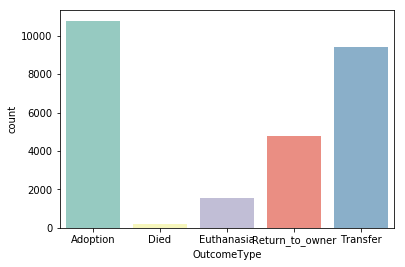

In [39]:
sns.countplot(animals.OutcomeType, palette='Set3')

### Exploring our features:

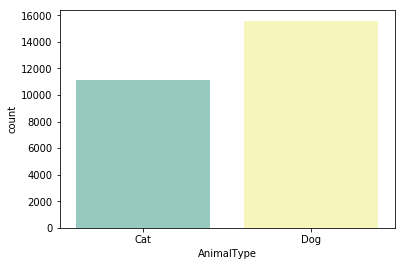

In [25]:
sns.countplot(animals.AnimalType, palette='Set3')

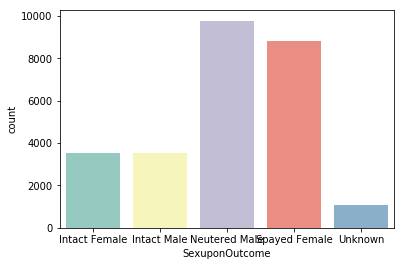

In [36]:
sns.countplot(animals.SexuponOutcome, palette='Set3')

### Feature Engineering:

In [124]:
# check different values for SexuponOutcome
animals['SexuponOutcome'].value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [157]:
# check for null values
animals['SexuponOutcome'].isna().sum()

1

In [158]:
# lets fill the nan value with unknown type
animals['SexuponOutcome'] = animals['SexuponOutcome'].fillna('Unknown')

In [159]:
# functions to create new features, sex and neutered
def get_sex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
def get_neutered(x):
    x = str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'

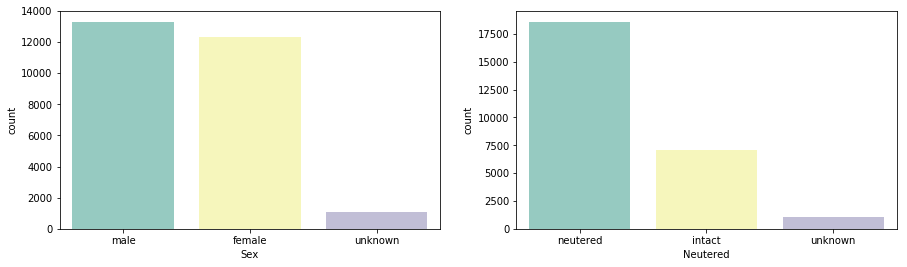

In [160]:
animals['Sex'] = animals.SexuponOutcome.apply(get_sex)
animals['Neutered'] = animals.SexuponOutcome.apply(get_neutered)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(animals.Sex, palette='Set3', ax=ax1)
sns.countplot(animals.Neutered, palette='Set3', ax=ax2)

In [161]:
# lets now drop SexuponOutcome column
animals = animals.drop('SexuponOutcome', axis = 1)

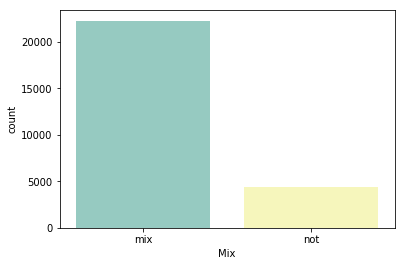

In [162]:
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'mix'
    return 'not'
animals['Mix'] = animals.Breed.apply(get_mix)
sns.countplot(animals.Mix, palette='Set3')

In [182]:
# lets now drop Breed column
animals = animals.drop('Breed', axis = 1)

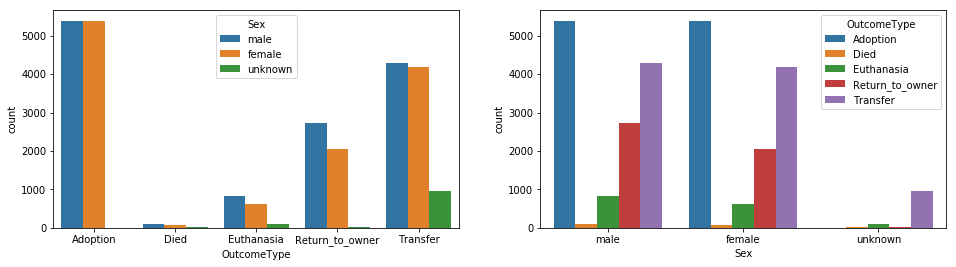

In [163]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=animals, x='Sex',hue='OutcomeType', ax=ax2)

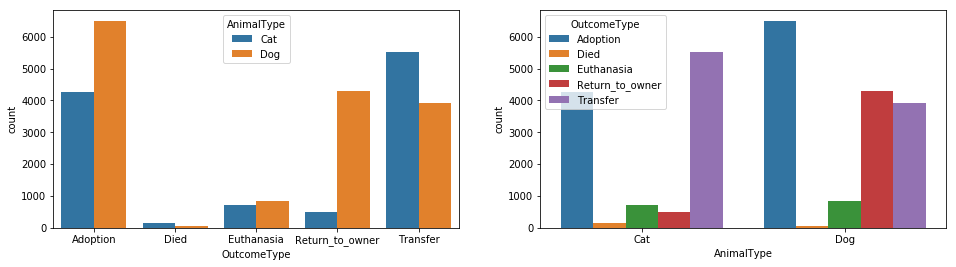

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='OutcomeType',hue='AnimalType', ax=ax1)
sns.countplot(data=animals, x='AnimalType',hue='OutcomeType', ax=ax2)

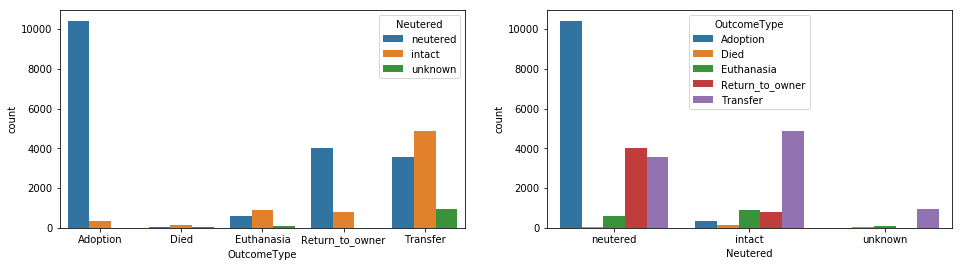

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='OutcomeType',hue='Neutered', ax=ax1)
sns.countplot(data=animals, x='Neutered',hue='OutcomeType', ax=ax2)

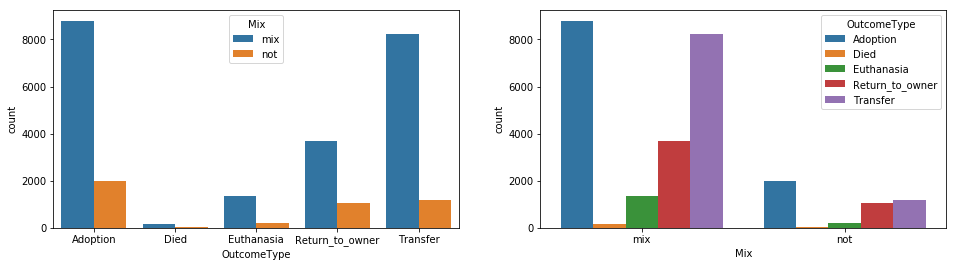

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='OutcomeType',hue='Mix', ax=ax1)
sns.countplot(data=animals, x='Mix',hue='OutcomeType', ax=ax2)

In [95]:
animals['AgeuponOutcome'].value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [164]:
# check for null values
animals['AgeuponOutcome'].isna().sum()

18

In [165]:
# let us now drop these null values
animals = animals.dropna(subset=['AgeuponOutcome'])

In [166]:
def calc_age_in_years(x):
    x = str(x)
    age = int(x.split()[0])
    if x.find('year') > -1: return float(format(age,'.2f')) 
    if x.find('month')> -1: return float(format((age / 12),'.2f'))
    if x.find('week')> -1: return float(format((age / 52),'.2f'))
    if x.find('day')> -1: return float(format((age / 365),'.2f'))
    else: return 0

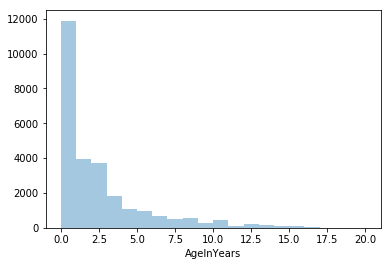

In [167]:
animals['AgeInYears'] = animals.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(animals.AgeInYears, bins = 20, kde=False)

In [114]:
animals['AgeInYears'].describe()

count    26711.000000
mean         2.177612
std          2.965513
min          0.000000
25%          0.170000
50%          1.000000
75%          3.000000
max         20.000000
Name: AgeInYears, dtype: float64

In [168]:
def calc_age_category(x):
    if x <= 10: return 'young'
    else: return 'adult'
animals['AgeCategory'] = animals.AgeInYears.apply(calc_age_category)

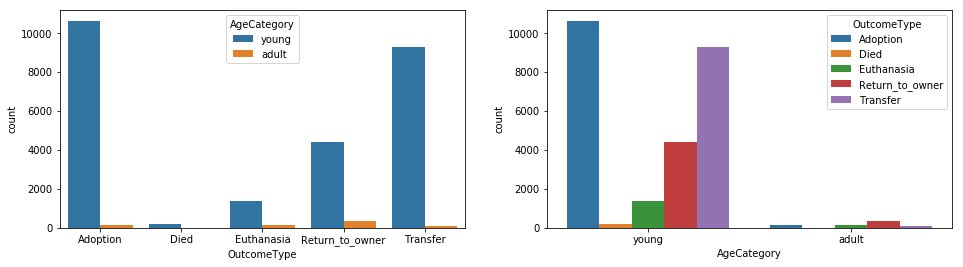

In [169]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=animals, x='OutcomeType',hue='AgeCategory', ax=ax1)
sns.countplot(data=animals, x='AgeCategory',hue='OutcomeType', ax=ax2)

In [170]:
# lets now drop AgeuponOutcome column
animals = animals.drop('AgeuponOutcome', axis = 1)

In [171]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26711 entries, 0 to 26728
Data columns (total 10 columns):
OutcomeType       26711 non-null category
OutcomeSubtype    13099 non-null category
AnimalType        26711 non-null category
Breed             26711 non-null category
Color             26711 non-null category
Sex               26711 non-null object
Neutered          26711 non-null object
Mix               26711 non-null object
AgeInYears        26711 non-null float64
AgeCategory       26711 non-null object
dtypes: category(5), float64(1), object(4)
memory usage: 2.7+ MB


In [172]:
# converting engineered features to categorical types
cat_columns = ['Sex', 'Neutered', 'Mix', 'AgeCategory']
for col in cat_columns:
    animals[col] = animals[col].astype('category')
animals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26711 entries, 0 to 26728
Data columns (total 10 columns):
OutcomeType       26711 non-null category
OutcomeSubtype    13099 non-null category
AnimalType        26711 non-null category
Breed             26711 non-null category
Color             26711 non-null category
Sex               26711 non-null category
Neutered          26711 non-null category
Mix               26711 non-null category
AgeInYears        26711 non-null float64
AgeCategory       26711 non-null category
dtypes: category(9), float64(1)
memory usage: 2.0 MB


In [174]:
# explore OutcomeSubtype feature values
animals['OutcomeSubtype'].value_counts()

Partner                7816
Foster                 1800
SCRP                   1583
Suffering              1000
Aggressive              320
Offsite                 165
In Kennel               114
Behavior                 86
Rabies Risk              74
Medical                  66
In Foster                52
Enroute                   8
Court/Investigation       6
At Vet                    4
In Surgery                3
Barn                      2
Name: OutcomeSubtype, dtype: int64

In [175]:
# check for null values
animals['OutcomeSubtype'].isna().sum()

13612

In [176]:
# explore shape of data
animals.shape

(26711, 10)

In [178]:
# From above, we see that half of the values in OutcomeSubtype is null. Hence, let us drop that column.
animals = animals.drop('OutcomeSubtype', axis = 1)

In [180]:
# Also, there is a redundant AgeCategory column for data modelling as we already have AgeInYears. 
#Hence, let us now drop AgeCategory column as well.
animals = animals.drop('AgeCategory', axis = 1)

### Data Modeling:

In [186]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26711 entries, 0 to 26728
Data columns (total 7 columns):
OutcomeType    26711 non-null category
AnimalType     26711 non-null category
Color          26711 non-null category
Sex            26711 non-null category
Neutered       26711 non-null category
Mix            26711 non-null category
AgeInYears     26711 non-null float64
dtypes: category(6), float64(1)
memory usage: 1.8 MB


In [187]:
def convert_to_numeric(df):
    for col in ['AnimalType', 'Color', 'OutcomeType', 'Sex', 'Neutered', 'Mix', 'AgeInYears']: 
        if col in df.columns:
            _col = "_%s" % (col)
            values = df[col].unique() 
            _values = dict(zip(values, range(len(values)))) 
            df[_col] = df[col].map(_values).astype(int) 
            df = df.drop(col, axis = 1)
    return df

In [188]:
# converting columns to numeric
animals = convert_to_numeric(animals)